# Project: Participate in Kaggle Competition “Google Research - Identify Contrails to Reduce Global Warming”

## Context
The project consisted in entering a Kaggle competition with the objective of training a machine learning model to identify contrails in satellite images and help prevent their formation.
For context contrails are condensation trails, which are long, thin ice crystals clouds that form in an aircraft engine when it flies in humid areas.  Some of these contrails can linger and grow for several hours, occasionally merging into cloud formations that become visually identical to naturally occurring cirrus, making them difficult to detect and they can contribute to global warming by trapping heat in the atmosphere. The reason why it could be important to detect them is to help researchers improve the accuracy of their contrail models that predict when contrails will form and how much warming they will cause by validating these models with satellite imagery. This will help airlines avoid creating contrails and reduce their impact on climate change. 

## Data
The dataset provided by the challenge consisted of geostationary satellite images retrieved from the GOES-16 Advanced Baseline Imager (ABI). The train data consists of multiple sequences of images with one main labeled image. As contrails are easier to identify with temporal context, the challenge provides a sequence of images at 10-minute intervals, 4 before the labeled image and 3 after. For each of these sequences, there are 9 different folders that represent bands that are the infrared channel at different wavelengths and are converted to brightness temperatures. 

## Imports

In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler 
import torch.amp 
from tqdm.notebook import tqdm
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython import display
from torch.cuda.amp import autocast

## Reproducibility

In [2]:
# Class that seeds everything to get reproducible results
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Dataset
The competition provides numpy arrays for each record_id, where there are 9 folders for each band (band_08 to band_16) in each record_id. The input of the model will be a version of the sequences but with only three channels (RGB) following the ash color scheme using only bands 11, 14 and 15.
Each band folder contains an array (256, 256, 8). 
These are a sequence of 8 images of size 256x256.
Need to convert data to tensors with shape (C,T,H,W)->(3,8,256,256)
C->Channels(3 channels from the ash color scheme); T->(sequence=8 images in sequence); H->Height=256; W->Width=256
The label is an array (H, W, 1) that is the per pixel binary ground truth

### Parameters and normalization function for Ash Color Scheme
The ash color scheme uses the satellite bands to make images in RGB that make contrails appear in the image as dark blue. 
R = Band 15 - Band 14<br>
G = Band 14 - Band 11<br>
B = Band 14 <br>
**Competition code reference:** Inversion. Ng, Joe. (2023). Visualizing Contrails [Source code]. Kaggle. https://www.kaggle.com/code/inversion/visualizing-contrails

In [3]:
# Bounds for Ash Color Scheme
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

# Normalization function for Ash Color Scheme
def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

### Quick visualization
Replicated **Competition code reference:** Inversion. Ng, Joe. (2023). Visualizing Contrails [Source code]. Kaggle. https://www.kaggle.com/code/inversion/visualizing-contrails

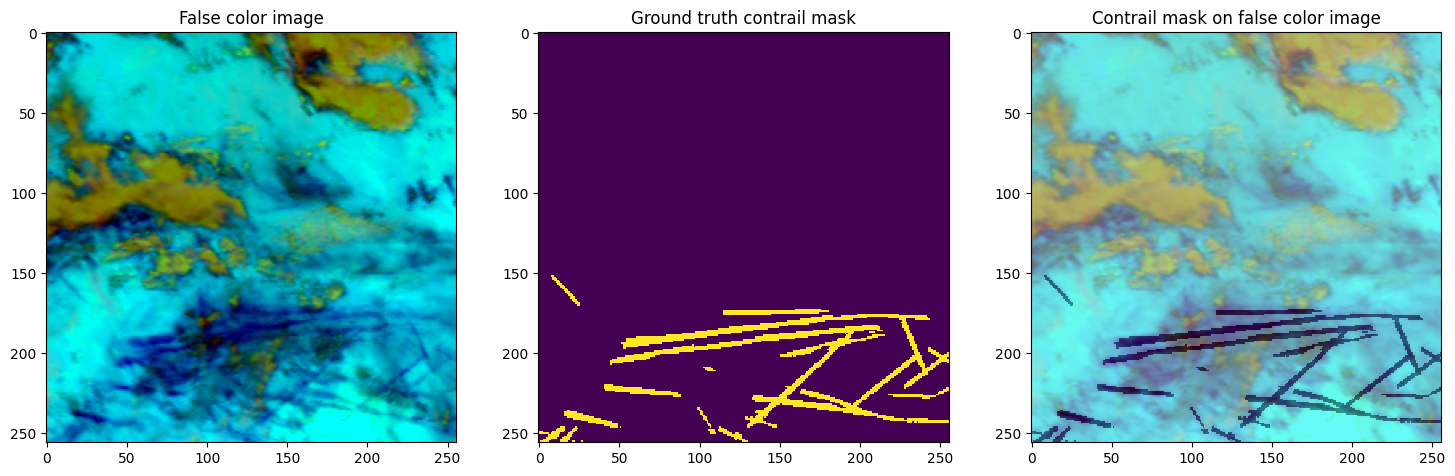

In [4]:
BASE_DIR = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/train'
N_TIMES_BEFORE = 4
record_id = '1704010292581573769'

with open(os.path.join(BASE_DIR, record_id, 'band_11.npy'), 'rb') as f:
    band11 = np.load(f)
with open(os.path.join(BASE_DIR, record_id, 'band_14.npy'), 'rb') as f:
    band14 = np.load(f)
with open(os.path.join(BASE_DIR, record_id, 'band_15.npy'), 'rb') as f:
    band15 = np.load(f)
with open(os.path.join(BASE_DIR, record_id, 'human_pixel_masks.npy'), 'rb') as f:
    human_pixel_mask = np.load(f)
with open(os.path.join(BASE_DIR, record_id, 'human_individual_masks.npy'), 'rb') as f:
    human_individual_mask = np.load(f)

r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
b = normalize_range(band14, _T11_BOUNDS)
false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)

img = false_color[..., N_TIMES_BEFORE]

plt.figure(figsize=(18, 6))
ax = plt.subplot(1, 3, 1)
ax.imshow(img)
ax.set_title('False color image')

ax = plt.subplot(1, 3, 2)
ax.imshow(human_pixel_mask, interpolation='none')
ax.set_title('Ground truth contrail mask')

ax = plt.subplot(1, 3, 3)
ax.imshow(img)
ax.imshow(human_pixel_mask, cmap='Reds', alpha=.4, interpolation='none')
ax.set_title('Contrail mask on false color image');

### Pytorch Dataset

In [5]:
class ContrailDataset(Dataset):
    """
    Loads the sequences, calculates Ash Color Scheme, and returns 3D tensors.
    Input Shape: (H, W, T) from numpy files.
    Output Shape: (C, T, H, W) for PyTorch 3D Conv.
    """
    def __init__(self, data_dir, record_ids, train_mode=True):
        self.root = Path(data_dir) 
        self.record_ids = list(record_ids)
        self.train_mode = train_mode

    def __len__(self):
        return len(self.record_ids)

    def __getitem__(self, idx):
        rid = self.record_ids[idx]
        rid_path = self.root / rid

        # Load Bands (Shape: 256, 256, 8)
        band11 = np.load(rid_path / "band_11.npy").astype(np.float32)
        band14 = np.load(rid_path / "band_14.npy").astype(np.float32)
        band15 = np.load(rid_path / "band_15.npy").astype(np.float32)

        # Calculate Ash Color Scheme
        # R = Band 15 - Band 14
        r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
        # G = Band 14 - Band 11
        g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
        # B = Band 14
        b = normalize_range(band14, _T11_BOUNDS)

        # Stack to (3, 256, 256, 8)
        rgb = np.stack([r, g, b], axis=0)
        rgb = np.clip(rgb, 0, 1)

        # Transpose from (C, H, W, T) to (C, T, H, W)
        rgb = np.transpose(rgb, (0, 3, 1, 2)) 

        # Load Label (Only for Train/Validation)
        label_path = rid_path / "human_pixel_masks.npy"
        if label_path.exists():
            label = np.load(label_path).astype(np.float32)
            label = label[..., 0] # Remove channel (256, 256)
            label = np.expand_dims(label, 0) # Add channel in the first position (1, 256, 256)
            return torch.from_numpy(rgb), torch.from_numpy(label)
        else:
            # For Test set (no labels)
            return torch.from_numpy(rgb), rid

## Model (3D U-Net with ConvLSTM in Bottle Neck)
3D U-Net is a model that is widely used for 3D image segmentation that consists of 3D convolutional layers and a symmetrical encoder-decoder structure with skip connections to segment volumetric data. In this project the 3D data is provided by the temporal information. Instead of just doing the 3D convolutions in the bottle neck of the U-Net, to better process temporal context,  a ConvLSTM model was used to model temporal evolution of contrail formation so the model learns how features evolve over time.

In [6]:
# Sigle Convolution Long Short-Term Memory
class ConvLSTMCell(nn.Module):
    """
    A single step of ConvLSTM
    """
    def __init__(self, input_channels, hidden_channels, kernel_size=3):
        """
        Initialize ConvLSTM cell

        input_channels (int): Number of channels of input tensor.  
        hidden_channels (int): Number of channels of hidden state.   
        kernel_size (int): Size of the convolutional kernel.
        """
        super().__init__()
        # Initialize
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        padding = kernel_size // 2
        # Compute input, forget, cell, and output gates
        self.conv = nn.Conv2d(input_channels + hidden_channels, 4 * hidden_channels, kernel_size, padding=padding)

    def forward(self, x, h, c):
        """
        x: (B, C_in, H, W)
        h, c: (B, C_hidden, H, W)
        returns: h_next, c_next
        """
        # Concatenate input and previous hidden state along channel axis
        combined = torch.cat([x, h], dim=1)
        # Convolution 
        gates = self.conv(combined)
        # Split into input gate, forget gate, candidate, output gate
        i, f, g, o = torch.chunk(gates, 4, dim=1)
        # Nonlinearities
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        g = torch.tanh(g)
        o = torch.sigmoid(o)
        # Update
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

class ConvLSTM(nn.Module):
    """
    Full ConvLSTM using ConvLSTMCell
    """
    def __init__(self, input_channels, hidden_channels, kernel_size=3):
        super().__init__()
        self.cell = ConvLSTMCell(input_channels, hidden_channels, kernel_size)

    def forward(self, x):
        """
        x: (Batch, Channel, Time, Height, Width)
        """
        B, C, T, H, W = x.shape
        # Initial h and c 
        h = torch.zeros(B, self.cell.hidden_channels, H, W, device=x.device)
        c = torch.zeros(B, self.cell.hidden_channels, H, W, device=x.device)
        
        outputs = []
        # Loop through each time step
        for t in range(T):
            # time step
            x_t = x[:, :, t, :, :] 
            # One step of ConvLSTMCell
            h, c = self.cell(x_t, h, c)
            # add time dimension back (B, C, 1, H, W)
            outputs.append(h.unsqueeze(2)) 
            
        # Concatenate along time axis
        return torch.cat(outputs, dim=2), (h, c)

# Code from Wen, Q. (2020). ConvLSTM PyTorch implementation [Code repository]. GitHub.
# https://github.com/ndrplz/ConvLSTM_pytorch

class Conv3DBlock(nn.Module):
    """
    Standard 3D Convolution Block
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            # First 3×3×3 conv
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            # Second 3×3×3 conv
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.block(x)

# Main model
class UNet3D_ConvLSTM(nn.Module):
    """
    3D U-Net + ConvLSTM bottleneck.
    Input:  x  (B, C=3, T=8, H=256, W=266)
    Output: (B, 1, H, W) binary mask
    """
    def __init__(self, in_channels=3, base_channels=16):
        super().__init__()
        
        # Encoder
        self.enc1 = Conv3DBlock(in_channels, base_channels)
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2)) 
        
        self.enc2 = Conv3DBlock(base_channels, base_channels*2)
        self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        
        self.enc3 = Conv3DBlock(base_channels*2, base_channels*4)
        self.pool3 = nn.MaxPool3d(kernel_size=(1, 2, 2))
        
        # ConvLSTM Bottle neck
        # Input: (B, 64, 8, 32, 32)
        self.proj = nn.Conv3d(base_channels*4, base_channels*4, kernel_size=1)
        self.lstm = ConvLSTM(base_channels*4, base_channels*8, kernel_size=3)
        
        # Decoder (Expanding Path)
        self.up3 = nn.ConvTranspose3d(base_channels*8, base_channels*4, kernel_size=(1,2,2), stride=(1,2,2))
        self.dec3 = Conv3DBlock(base_channels*8, base_channels*4)
        
        self.up2 = nn.ConvTranspose3d(base_channels*4, base_channels*2, kernel_size=(1,2,2), stride=(1,2,2))
        self.dec2 = Conv3DBlock(base_channels*4, base_channels*2)
        
        self.up1 = nn.ConvTranspose3d(base_channels*2, base_channels, kernel_size=(1,2,2), stride=(1,2,2))
        self.dec1 = Conv3DBlock(base_channels*2, base_channels)
        
        # Head
        self.final = nn.Conv3d(base_channels, 1, kernel_size=1)

    def forward(self, x):
        # x: (B, 3, 8, 256, 256)
        
        # Encoder
        e1 = self.enc1(x) # (16, 8, 256, 256)
        p1 = self.pool1(e1) # (16, 8, 128, 128)
        
        e2 = self.enc2(p1) # (32, 8, 128, 128)
        p2 = self.pool2(e2) # (32, 8, 64, 64)
        
        e3 = self.enc3(p2) # (64, 8, 64, 64)
        p3 = self.pool3(e3) # (64, 8, 32, 32)
        
        # Bottleneck
        p3 = self.proj(p3)
        lstm_out, _ = self.lstm(p3) # (128, 8, 32, 32)
        
        # Decoder
        u3 = self.up3(lstm_out) # (64, 8, 64, 64)
        cat3 = torch.cat([u3, e3], dim=1) # Skip connection
        d3 = self.dec3(cat3)
        
        u2 = self.up2(d3) # (32, 8, 128, 128)
        cat2 = torch.cat([u2, e2], dim=1) # Skip connection
        d2 = self.dec2(cat2)
        
        u1 = self.up1(d2) # (16, 8, 256, 256)
        cat1 = torch.cat([u1, e1], dim=1) # Skip connection
        d1 = self.dec1(cat1)
        
        # Final Projection
        out_3d = self.final(d1) # (B, 1, 8, 256, 256)
        
        # Select the labeld image (5th image)
        out_2d = out_3d[:, :, 4, :, :] 
        
        return out_2d

## Loss Function
A combination of BCEWithLogitsLoss that combines a sigmoid layer and the Binary Cross Entropy Loss, and Dice Loss

In [7]:
# Dice Loss class
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, logits, target):
        probs = torch.sigmoid(logits)
        # Intersection of prediction and label pixels
        intersection = (probs * target).sum(dim=(1,2,3))
        # Denominator is the union of prediction and label pixels
        denom = probs.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) 
        dice = (2 * intersection + self.smooth) / (denom + self.smooth)
        return 1 - dice.mean()

# Initialize loss functions
bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()

def combined_loss(logits, targets, alpha=0.5):
    """
    50% bce loss and 50% dice loss
    """
    return alpha * bce_loss(logits, targets) + (1 - alpha) * dice_loss(logits, targets)


### Helper functions for one epoch

In [8]:
def train_one_epoch(model, loader, optimizer, scaler, device):
    model.train()
    running_loss = 0.0 # to track loss
    # iterate through batches
    for step, (x, y) in enumerate(loader, 1):
        # Move to GPU
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        # reset gradients
        optimizer.zero_grad()
        
        # mixed precision
        with autocast():
            # Forward pass
            logits = model(x)
            # Compute loss
            loss = combined_loss(logits, y)
            
        # Update
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Add loss to total
        running_loss += loss.item()
    
    return running_loss / len(loader)


def validate_global_dice(model, loader, device, threshold=0.5):
    """
    Calculates dice over the whole dataset.
    """
    model.eval()
    total_intersection = 0.0
    total_union = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).float()
            
            intersection = (preds * y).sum().item()
            union = (preds.sum() + y.sum()).item()
            
            total_intersection += intersection
            total_union += union
    return (2 * total_intersection) / (total_union + 1e-6)



## Prepare Data

In [9]:
# Reproducibility
seed_everything(42)

# Kaggle Paths
DATA_DIR = Path('/kaggle/input/google-research-identify-contrails-reduce-global-warming')
TRAIN_DIR = DATA_DIR / 'train'
VALID_DIR = DATA_DIR / 'validation'
TEST_DIR = DATA_DIR / 'test'

# Record_ids
train_ids = sorted(os.listdir(TRAIN_DIR))
val_ids = sorted(os.listdir(VALID_DIR))

# Convert data to tensors to input model
train_ds = ContrailDataset(TRAIN_DIR, train_ids)
val_ds = ContrailDataset(VALID_DIR, val_ids)

# Data Loaders
BATCH_SIZE = 2
NUM_WORKERS = 2
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS, pin_memory=True)

# device used was the Kaggle GPU T4 x2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize model
EPOCHS = 15
BATCH_SIZE = 2 
LR = 1e-4
model = UNet3D_ConvLSTM(in_channels=3, base_channels=16).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)
scaler = GradScaler()

/tmp/ipykernel_20/3681955855.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


## Training

In [10]:
best_global_dice = 0.0
save_path = "best_model.pth"

print(f"Starting Training for {EPOCHS} Epochs...")

for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss = train_one_epoch(model, train_loader, optimizer, scaler, DEVICE)
    
    # Global dice validation
    val_global_dice = validate_global_dice(model, val_loader, DEVICE, threshold=0.5)

    print(f"Epoch {epoch} | Loss: {train_loss:.4f} | Global Dice: {val_global_dice:.4f}")

    if val_global_dice > best_global_dice:
        best_global_dice = val_global_dice
        torch.save(model.state_dict(), save_path)
        print("  --> Saved New Best Model!")

print(f"Training Done. Best Global Dice: {best_global_dice:.5f}")

Starting Training for 15 Epochs...


/tmp/ipykernel_20/2242015924.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Loss: 0.4559 | Global Dice: 0.3654
  --> Saved New Best Model!
Epoch 2 | Loss: 0.4175 | Global Dice: 0.3984
  --> Saved New Best Model!
Epoch 3 | Loss: 0.4097 | Global Dice: 0.4417
  --> Saved New Best Model!
Epoch 4 | Loss: 0.4039 | Global Dice: 0.4776
  --> Saved New Best Model!
Epoch 5 | Loss: 0.3998 | Global Dice: 0.4785
  --> Saved New Best Model!
Epoch 6 | Loss: 0.3966 | Global Dice: 0.4594
Epoch 7 | Loss: 0.3935 | Global Dice: 0.5007
  --> Saved New Best Model!
Epoch 8 | Loss: 0.3909 | Global Dice: 0.5081
  --> Saved New Best Model!
Epoch 9 | Loss: 0.3882 | Global Dice: 0.5024
Epoch 10 | Loss: 0.3862 | Global Dice: 0.5199
  --> Saved New Best Model!
Epoch 11 | Loss: 0.3848 | Global Dice: 0.5127
Epoch 12 | Loss: 0.3823 | Global Dice: 0.4941
Epoch 13 | Loss: 0.3809 | Global Dice: 0.5475
  --> Saved New Best Model!
Epoch 14 | Loss: 0.3790 | Global Dice: 0.5253
Epoch 15 | Loss: 0.3772 | Global Dice: 0.5011
Training Done. Best Global Dice: 0.54751


## Visualization of predictions

In [11]:

def visualize_prediction(model, dataset, target=None, threshold=0.5):
    """
    Visualizes a prediction against ground truth.
    
    model: The trained PyTorch model.
    dataset: The validation dataset.
    target: Can be an the index or record_id.
    threshold: Probability threshold for binary mask.
    """
    # Determine which index to load
    idx = 0
    if target is None:
        idx = random.randint(0, len(dataset)-1)
    elif isinstance(target, int):
        idx = target
    elif isinstance(target, str):
        try:
            # Find the index of the string ID in the dataset list
            idx = dataset.record_ids.index(target)
        except ValueError:
            print(f"Error: Record ID '{target}' not found in this dataset.")
            return
            
    # Load the data
    # x: (3, 8, 256, 256), y_true: (1, 256, 256)
    x, y_true = dataset[idx] 
    record_id = dataset.record_ids[idx]
    
    # Add batch dimension -> (1, 3, 8, 256, 256)
    x_in = x.unsqueeze(0).to(DEVICE) 
    
    # Run
    model.eval()
    with torch.no_grad():
        logits = model(x_in)
        # # Convert logits to probabilities (0 to 1)
        probs = torch.sigmoid(logits)
        # conver to binary mask
        y_pred = (probs > threshold).float().cpu().numpy()[0, 0]
        
    # Prepare Images for Plotting
    ash_img = x[:, 4, :, :].numpy().transpose(1, 2, 0) 
    y_true = y_true[0].numpy()
    
    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    # Ash Color Image
    ax[0].imshow(ash_img)
    ax[0].set_title(f"Record: {record_id}\n(Index: {idx})")
    ax[0].axis('off')
    
    # Ground Truth
    ax[1].imshow(y_true, cmap='gray')
    ax[1].set_title("Ground Truth Mask")
    ax[1].axis('off')
    
    # Prediction
    ax[2].imshow(y_pred, cmap='gray')
    ax[2].set_title(f"Model Prediction\n(Threshold > {threshold})")
    ax[2].axis('off')
    
    plt.show()


Visualizing Example without Contrails


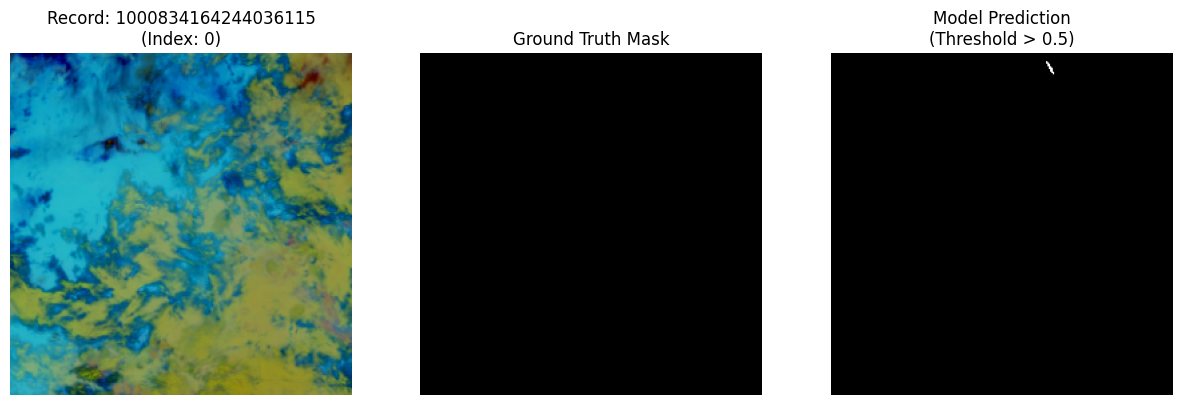

Visualizing Example with Contrails


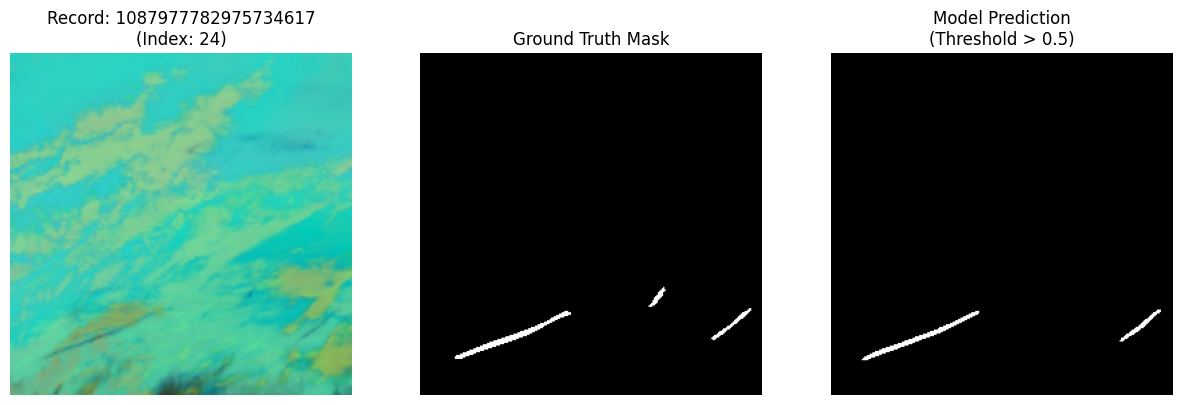

In [12]:
# Load best model weights
model.load_state_dict(torch.load("best_model.pth"))

print("Visualizing Example without Contrails")
visualize_prediction(model, val_ds, target='1000834164244036115')

#print("\n" + "="*50 + "\n")

print("Visualizing Example with Contrails")
visualize_prediction(model, val_ds, target='1087977782975734617')


## Generate Submission File
Based on **Competition code reference:** Inversion. Ng, Joe. (2023). Contrails - RLE Submission [Source code]. Kaggle. https://www.kaggle.com/code/inversion/contrails-rle-submission


In [13]:
def rle_encode(x, fg_val=1):
    """
    Encoding for submission.
    x (numpy array): mask (1=contrail, 0=bg)
    Returns: list of run lengths
    """
    # 1d array with that finds the indices of pixels where there are contrails
    dots = np.where(x.T.flatten() == fg_val)[0]
    run_lengths = []
    prev = -2 # Because indices start at 0
    for b in dots:
        # Check if the current pixel is not the neighbor of the previous pixel
        if b > prev + 1:
            # Add start position
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b # update
    return run_lengths

def list_to_string(x):
    """
    Converts RLE list to string for CSV
    """
    if x:
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s

In [14]:
print("\nGenerating Submission.csv...")
# list of test record ids
test_ids = sorted(os.listdir(TEST_DIR))
# Data loader for test images
test_ds = ContrailDataset(TEST_DIR, test_ids)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

submission_data = []
model.eval()
#disable gradiant
with torch.no_grad():
    for x, rids in test_loader:
        x = x.to(DEVICE)

        # Get raw model outputs
        logits = model(x)
        # Convert logits to probabilities (0 to 1)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float().cpu().numpy()[:, 0, :, :]

        # Loop through each image in the batch
        for i, rid in enumerate(rids):
            # Extract single image mask
            mask = preds[i]
            # Encode
            rle = rle_encode(mask)
            rle_str = list_to_string(rle)
            
            submission_data.append({
                "record_id": rid,
                "encoded_pixels": rle_str
            })

df_sub = pd.DataFrame(submission_data)
df_sub.to_csv("submission.csv", index=False)
print("submission.csv saved")
print(df_sub.head())


Generating Submission.csv...
submission.csv saved
             record_id                                   encoded_pixels
0  1000834164244036115  41223 2 41480 3 41737 4 41995 4 42252 4 42511 2
1  1002653297254493116                                                -
